### Table of contents


[- Data cleaning](#Data-cleaning)  
[- Neural network training and validating](#Neural-network-training-and-validating)

Neural network training and validating

In [57]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, jaccard_score, pairwise_distances
import matplotlib.pyplot as plt
import nbimporter
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from torch.utils.data import DataLoader, TensorDataset
import torch
import torch.nn as nn
import torch.optim as optim

#Finding current file path and checking for cuda
from pathlib import Path
current_path = Path().resolve()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [58]:
#Both datasets are imported
df_songs = pd.read_csv(current_path / 'Data/Music Info.csv')

df_users = pd.read_csv(current_path / 'Data/User Listening History.csv')

***
<h3 id="data-cleaning" style="text-align: center;">Data cleaning</h3>

***

- Part of the data cleaning process is checking for null values, chec

In [62]:
print("df_songs dataset columns: ",df_songs.columns)
print("df_users dataset columns: ",df_users.columns)

df_songs dataset columns:  Index(['track_id', 'name', 'artist', 'tags', 'genre', 'year', 'duration_ms',
       'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'time_signature'],
      dtype='object')
df_users dataset columns:  Index(['track_id', 'user_id', 'playcount'], dtype='object')


In [59]:
#Inorder to simplify the data preprocessing all columns not used in the project is removed:
df_songs = df_songs.drop(columns=["spotify_preview_url","spotify_id"])
df_songs.describe()

,year,duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
count,50683.000000,5.068300e+04,50683.000000,50683.000000,50683.000000,50683.000000,50683.000000,50683.000000,50683.000000,50683.000000,50683.000000,50683.000000,50683.000000,50683.000000
mean,2004.017323,2.511551e+05,0.493537,0.686486,5.312748,-8.291204,0.631060,0.076023,0.213808,0.225283,0.215425,0.433134,123.507682,3.898151
std,8.860172,1.075860e+05,0.178838,0.251808,3.568078,4.548365,0.482522,0.076007,0.302848,0.337049,0.184697,0.258779,29.621125,0.419670
min,1900.000000,1.439000e+03,0.000000,0.000000,0.000000,-60.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2001.000000,1.927330e+05,0.364000,0.514000,2.000000,-10.375000,0.000000,0.035200,0.001400,0.000018,0.098400,0.214000,100.683000,4.000000
50%,2006.000000,2.349330e+05,0.497000,0.744000,5.000000,-7.200000,1.000000,0.048200,0.039900,0.005630,0.138000,0.405000,121.989000,4.000000
75%,2009.000000,2.881930e+05,0.621000,0.905000,9.000000,-5.089000,1.000000,0.083500,0.340000,0.441000,0.289000,0.634000,141.639000,4.000000
max,2022.000000,3.816373e+06,0.986000,1.000000,11.000000,3.642000,1.000000,0.954000,0.996000,0.999000,0.999000,0.993000,238.895000,5.000000


In [17]:
df_users.describe()

,playcount
count,9.711301e+06
mean,2.630946e+00
std,5.706324e+00
min,1.000000e+00
25%,1.000000e+00
50%,1.000000e+00
75%,2.000000e+00
max,2.948000e+03


In [ ]:
#The shape of each dataset
print("Music info dataset shape: ",df_songs.shape)
print("User listening shape: ",df_users.shape)

Music info dataset shape:  (50683, 21)
User listening shape:  (9711301, 3)


In [21]:
#Ckecking for nulls in each column in df_songs
null_count = df_songs.isnull().sum()
null_count = null_count[null_count > 0]
print("Number of null elements in column")
print(null_count)

print("---------------")
rows_with_nulls_count = df_songs.isnull().any(axis=1).sum()
print("Rows consisting of 1 or more null values: ",rows_with_nulls_count)

Number of null elements in column
tags      1127
genre    28335
dtype: int64
---------------
Rows consisting of 1 or more null values:  28767


In [20]:
#Ckecking for nulls in each column in df_users
null_count = df_users.isnull().sum()
null_count = null_count[null_count > 0]
print("Number of null elements in column")
print(null_count)

print("---------------")
rows_with_nulls_count = df_users.isnull().any(axis=1).sum()
print("Rows consisting of 1 or more null values: ",rows_with_nulls_count)

Number of null elements in column
Series([], dtype: int64)
---------------
Rows consisting of 1 or more null values:  0


In [ ]:
# Get unique track_id values
unique_track_ids = df_songs['track_id'].unique()
print(f"Number of unique track_ids: {len(unique_track_ids)}")

# All songs are unique in the df_songs dataset


Number of unique track_ids: 50683


Because the songs dataset contains a significant number of null values in the genre column, it is split into two subsets: one containing all rows with available genres and the other containing the remaining rows with missing genres. A neural network is then used to predict the missing song genres, enabling their inclusion in the recommendation model later.

In [23]:
# Separate rows where 'genre' is NaN
df_without = df_songs[df_songs['genre'].isna()]

# Separate rows where 'genre' is not NaN. 
df_with = df_songs[df_songs['genre'].notna()]


In [28]:
#The shape of each dataset
print("Song dataset with genre: ",df_with.shape)
print("Song dataset without genre: ",df_without.shape)

Song dataset with genre:  (22348, 19)
Song dataset without genre:  (28335, 19)


In [31]:
print(df_with['genre'].value_counts())

genre
Rock          9965
Electronic    3710
Metal         2516
Pop           1145
Rap            821
Jazz           793
RnB            696
Reggae         691
Country        607
Punk           383
Folk           355
New Age        237
Blues          189
World          140
Latin          100
Name: count, dtype: int64


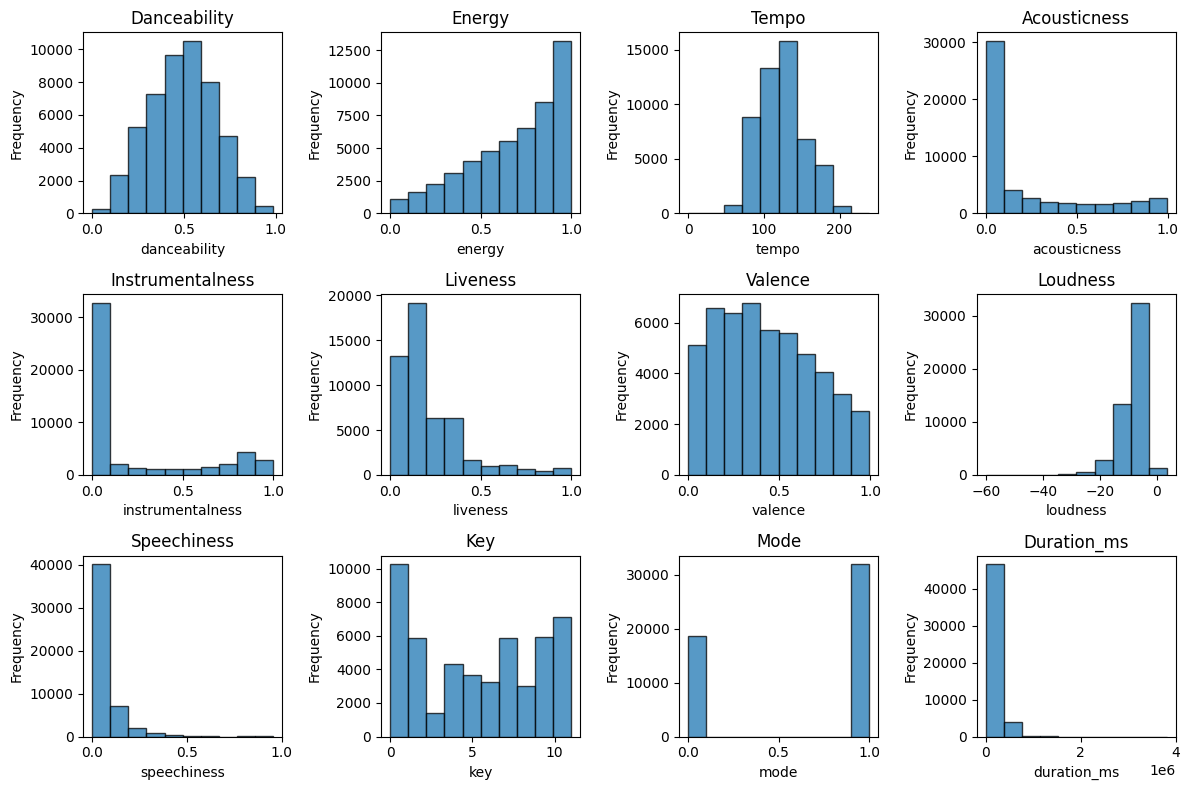

In [27]:
# List of numerical variables
numerical_variables = ['danceability', 'energy', 'tempo', 'acousticness', 'instrumentalness',
                        'liveness', 'valence', 'loudness', 'speechiness', 'key', 'mode', 'duration_ms']

# Setting up the layout for subplots: 3x4 quadrant
plt.figure(figsize=(12, 8))  # Adjust the size of the figure

# Loop through the numerical variables and create a subplot for each
for i, var in enumerate(numerical_variables):
    plt.subplot(3, 4, i + 1)
    plt.hist(df_songs[var], bins=10, edgecolor='black', alpha=0.75)  # Adjust bins as needed
    plt.title(var.capitalize())
    plt.xlabel(var)
    plt.ylabel('Frequency')

plt.tight_layout()  # Adjust spacing between subplots
plt.show()


In [ ]:
# Get the unique artist values from both datasets
unique_in_df_with = set(df_with['artist'].unique())
unique_in_df_without = set(df_without['artist'].unique())

# Find artists in df_without but not in df_with
artists_only_in_df_without = unique_in_df_without - unique_in_df_with

# Print the number of unique artists and some samples
print(f"Number of unique artists in df_without but not in df_with: {len(artists_only_in_df_without)}")

Number of unique artists in df_without but not in df_with: 3169
Sample of unique artists in df_without but not in df_with:
['Agent Alvin', 'John Mellencamp', 'Kendji Girac', 'Maduk', 'Woods', 'Albert Hammond', 'Clark', 'Champaign', 'Cor Scorpii', 'El Guincho']


In [ ]:
print(len(df_songs[df_songs['artist'].isin(artists_only_in_df_without)]))

The Rolling Stones    132
Radiohead             111
Autechre              105
Tom Waits             100
Bob Dylan              98
                     ... 
Ijahman Levi            1
I Wayne                 1
Saïan Supa Crew         1
Mr. Vegas               1
ACIDMAN                 1
Name: artist, Length: 8317, dtype: int64


***
<h3 id="#Neural-network-training-and-validating" style="text-align: center;">Neural network training and validating</h3>

***

In [48]:
# Neural Network

# Select features for one-hot encoding (categorical features)
categorical_features = ['artist']

# **Add 'Unknown' to the list of known artists**
known_artists = df_with['artist'].unique().tolist()
known_artists.append('Unknown')

# **Define the OneHotEncoder with the known categories**
onehot_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore', categories=[known_artists])

# **Fit the encoder on df_with**
onehot_encoded = onehot_encoder.fit_transform(df_with[categorical_features])

# Convert the one-hot encoded features to a DataFrame
onehot_encoded_with_df = pd.DataFrame(onehot_encoded, columns=onehot_encoder.get_feature_names_out(categorical_features))

# Merge the one-hot encoded features with the numerical features
numerical_features_with = df_with[['year', 'danceability', 'energy', 'tempo', 'acousticness', 'instrumentalness',
                                   'liveness', 'valence', 'loudness', 'speechiness', 'duration_ms', 'key', 'mode']]

# Combine numerical and one-hot encoded categorical features
X_with = pd.concat([numerical_features_with.reset_index(drop=True),
                    onehot_encoded_with_df.reset_index(drop=True)], axis=1)

y = df_with['genre']

# Encode genres
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# **Replace unknown artists in df_without with 'Unknown'**
df_without['artist'] = df_without['artist'].apply(
    lambda x: x if x in set(df_with['artist']) else 'Unknown'
)

# **Transform df_without using the same encoder**
onehot_encoded_without = onehot_encoder.transform(df_without[categorical_features])
onehot_encoded_without_df = pd.DataFrame(onehot_encoded_without,
                                         columns=onehot_encoder.get_feature_names_out(categorical_features))

# Process numerical features for df_without
numerical_features_without = df_without[['year', 'danceability', 'energy', 'tempo',
                                         'acousticness', 'instrumentalness', 'liveness',
                                         'valence', 'loudness', 'speechiness', 'duration_ms', 'key', 'mode']]

# Combine numerical and one-hot encoded categorical features for df_without
X_without = pd.concat([numerical_features_without.reset_index(drop=True),
                       onehot_encoded_without_df.reset_index(drop=True)], axis=1)

# **Split the data into training, validation, and test sets**
# First, split into train+validation and test sets
X_temp, X_test, y_temp, y_test = train_test_split(X_with, y_encoded, test_size=0.1, random_state=42, shuffle=True)

# Then, split the temp set into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1111, random_state=42, shuffle=True)
# Note: 0.1111 * 0.9 ≈ 0.1, so the validation set is approximately 10% of the original data

# **Check for overlap between training and validation sets**
train_indices = X_train.index
val_indices = X_val.index
overlap = train_indices.intersection(val_indices)
print(f"Number of overlapping samples between training and validation sets: {len(overlap)}")

# **Scale the data**
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)
X_without_scaled = scaler.transform(X_without)

# **Convert the data to PyTorch tensors**
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
X_without_tensor = torch.tensor(X_without_scaled, dtype=torch.float32)

y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# **Create TensorDataset and DataLoader for training, validation, and testing**
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 128  # Set your batch size

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define the Neural Network
class Net(nn.Module):
    def __init__(self, num_features, num_hidden1, num_hidden2, num_output):
        super(Net, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(num_features, num_hidden1),
            nn.BatchNorm1d(num_hidden1),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(num_hidden1, num_hidden2),
            nn.BatchNorm1d(num_hidden2),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(num_hidden2, num_output)
        )
    
    def forward(self, x):
        return self.model(x)

# Set model parameters
num_features = X_train_tensor.shape[1]  # Number of input features
num_hidden1 = 64  # Number of neurons in the first hidden layer
num_hidden2 = 32   # Number of neurons in the second hidden layer
num_output = len(set(y_train))  # Number of output classes

# Initialize the model
net = Net(num_features, num_hidden1, num_hidden2, num_output)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Multi-class classification loss
optimizer = optim.Adam(net.parameters(), lr=0.00005, weight_decay=1e-1)


Number of overlapping samples between training and validation sets: 0


In [50]:
# Training loop with validation and early stopping
def train_model_with_early_stopping(model, train_loader, val_loader, num_epochs=50, patience=5):
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    val_f1_scores = []  # To store validation F1 scores
    
    # Early stopping variables
    best_val_loss = float('inf')
    trigger_times = 0
    best_model_wts = None  # To save the best model weights

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Calculate average training loss
        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)

        # Calculate training accuracy in evaluation mode
        model.eval()
        with torch.no_grad():
            correct_train = 0
            total_train = 0
            for inputs, labels in train_loader:
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                total_train += labels.size(0)
                correct_train += (predicted == labels).sum().item()
        train_acc = correct_train / total_train
        train_accuracies.append(train_acc)

        # Validate on the validation set after each epoch
        val_loss, val_acc, val_f1 = validate_model(model, val_loader)  # Corrected to capture F1 score
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        val_f1_scores.append(val_f1)

        # Early stopping logic
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_wts = model.state_dict()  # Save the best model weights
            trigger_times = 0  # Reset patience counter
        else:
            trigger_times += 1
            print(f"Early stopping trigger count: {trigger_times}/{patience}")
            if trigger_times >= patience:
                print("Early stopping triggered. Stopping training.")
                break

        # Print results every epoch
        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Train Loss: {epoch_loss:.4f}, Train Accuracy: {train_acc:.4f}, "
              f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}, Validation F1 Score: {val_f1:.4f}")

    # Load the best model weights
    if best_model_wts is not None:
        model.load_state_dict(best_model_wts)
    else:
        print("No improvement in validation loss during training.")

    return train_losses, train_accuracies, val_losses, val_accuracies, val_f1_scores


# Call the training function with early stopping
train_losses, train_accuracies, val_losses, val_accuracies, val_f1_scores = train_model_with_early_stopping(
    net, train_loader, val_loader, num_epochs=50, patience=5
)

# Evaluate the model on the test set after training
test_loss, test_acc, test_f1 = validate_model(net, test_loader)
print(f"Final Test Loss: {test_loss:.4f}, Final Test Accuracy: {test_acc:.4f}, Final Test F1 Score: {test_f1:.4f}")


Epoch [1/50], Train Loss: 2.5540, Train Accuracy: 0.4436, Validation Loss: 2.4555, Validation Accuracy: 0.4304, Validation F1 Score: 0.3483
Epoch [2/50], Train Loss: 2.4381, Train Accuracy: 0.5092, Validation Loss: 2.3650, Validation Accuracy: 0.4931, Validation F1 Score: 0.4017
Epoch [3/50], Train Loss: 2.3266, Train Accuracy: 0.5569, Validation Loss: 2.2770, Validation Accuracy: 0.5230, Validation F1 Score: 0.4338
Epoch [4/50], Train Loss: 2.2143, Train Accuracy: 0.6031, Validation Loss: 2.1927, Validation Accuracy: 0.5673, Validation F1 Score: 0.4891
Epoch [5/50], Train Loss: 2.1206, Train Accuracy: 0.6365, Validation Loss: 2.1096, Validation Accuracy: 0.5946, Validation F1 Score: 0.5207
Epoch [6/50], Train Loss: 2.0215, Train Accuracy: 0.6514, Validation Loss: 2.0177, Validation Accuracy: 0.6089, Validation F1 Score: 0.5300
Epoch [7/50], Train Loss: 1.9353, Train Accuracy: 0.6686, Validation Loss: 1.9497, Validation Accuracy: 0.6206, Validation F1 Score: 0.5438
Epoch [8/50], Train 

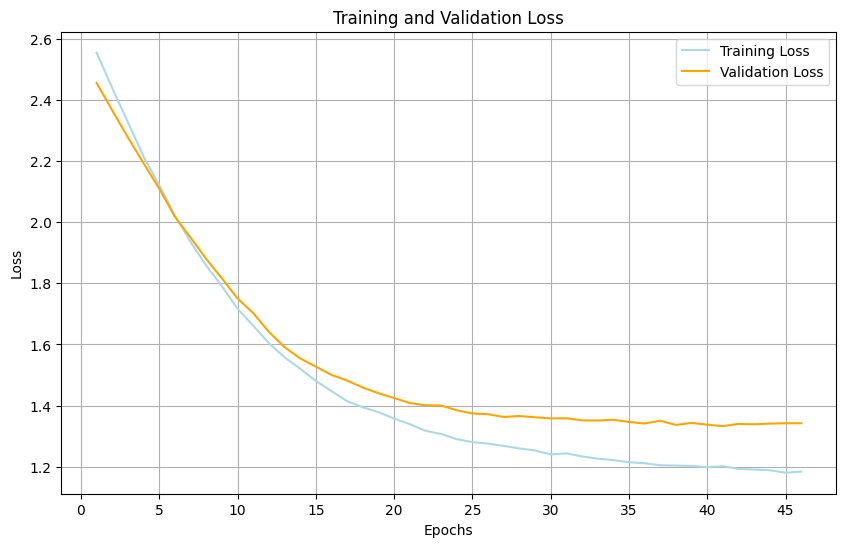

In [51]:
def plot_loss_curves(train_losses, val_losses):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_losses, color='lightblue', label='Training Loss')
    plt.plot(epochs, val_losses, color='orange', label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    
    # **Set x-axis ticks at intervals of 5**
    max_epoch = len(epochs)
    tick_positions = range(0, max_epoch + 1, 5)
    plt.xticks(tick_positions)
    
    plt.show()
# Call the plotting function
plot_loss_curves(train_losses, val_losses)

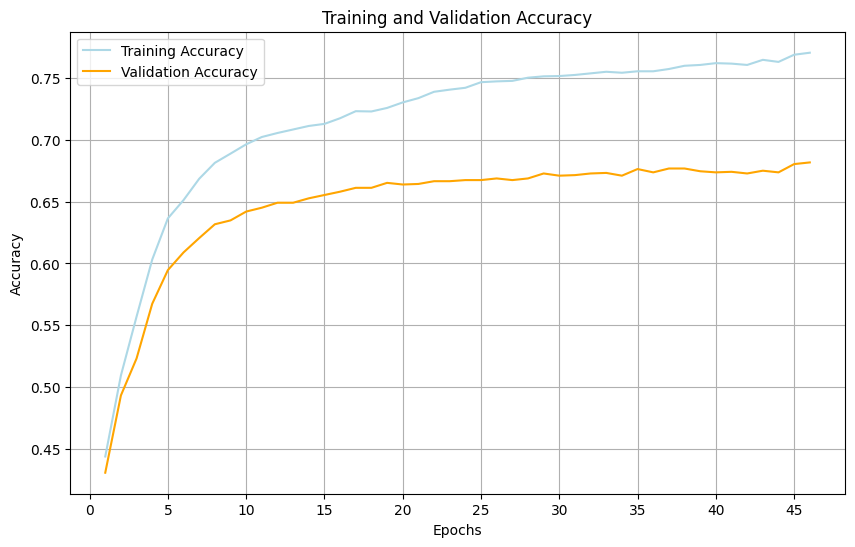

In [52]:
# After training is complete, plot the accuracy curves
def plot_accuracy_curves(train_accuracies, val_accuracies):
    epochs = range(1, len(train_accuracies) + 1)
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_accuracies, color='lightblue', label='Training Accuracy')
    plt.plot(epochs, val_accuracies, color='orange', label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True)
    
    # Set x-axis ticks at intervals of 5
    max_epoch = len(epochs)
    tick_positions = range(0, max_epoch + 1, 5)
    if 0 not in tick_positions:
        tick_positions = [0] + list(tick_positions)  # Ensure 0 is included
    plt.xticks(tick_positions)
    
    plt.show()

# Call the plotting function
plot_accuracy_curves(train_accuracies, val_accuracies)


In [54]:
# Ensure df_without is a copy to avoid modifying the original
df_without = df_without.copy()

# One-hot encode the categorical feature (artist) and merge with numerical features
numerical_features = df_without[['year', 'danceability', 'energy', 'tempo', 'acousticness',
                                 'instrumentalness', 'liveness', 'valence', 'loudness', 
                                 'speechiness', 'duration_ms', 'key', 'mode']].reset_index(drop=True)

# Directly transform and combine features
onehot_encoded = onehot_encoder.transform(df_without[['artist']])  # Uses the pre-fitted encoder
onehot_encoded_df = pd.DataFrame(onehot_encoded, columns=onehot_encoder.get_feature_names_out(['artist'])).reset_index(drop=True)
X_combined = pd.concat([numerical_features, onehot_encoded_df], axis=1)

# Scale and convert to PyTorch tensor
X_combined_scaled = scaler.transform(X_combined)  # Uses the pre-fitted scaler
X_combined_tensor = torch.tensor(X_combined_scaled, dtype=torch.float32)

# Predict genres using the trained model
net.eval()
with torch.no_grad():  # No gradients required
    predicted_genre_tensor = net(X_combined_tensor)
    predicted_genres = torch.argmax(predicted_genre_tensor, dim=1)

# Convert predictions back to labels and add to DataFrame
df_without['predicted_genre'] = label_encoder.inverse_transform(predicted_genres.numpy())


In [55]:
# Switching the already existing null genre column in df_without with the predcited genre from the NN
# Afterwards merging the two datasets to a combined one.
df_without['genre'] = df_without['predicted_genre']
df_without.drop('predicted_genre', axis=1, inplace=True)
df_combined = pd.concat([df_with, df_without], ignore_index=True)
df_combined = df_combined.sample(frac=1).reset_index(drop=True)
artist_mapping = df_songs.set_index('track_id')['artist']
df_combined['artist'] = df_combined['track_id'].map(artist_mapping)
df_combined.to_csv('Data/df_combined.csv', index=False)
df_combined.head()


,track_id,name,artist,tags,genre,year,duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,TRFTJPO128F428AA51,Ice Pick,Albert Collins,"blues, guitar, blues_rock",Electronic,2013,188933,0.607,0.685,0,-7.852,1,0.0317,0.5320,0.677000,0.3430,0.6330,94.660,4
1,TREDOHA128F4281ADA,When I Go Deaf,Low,"indie, indie_rock, post_rock",Rock,2004,281786,0.182,0.118,7,-10.413,1,0.0372,0.1130,0.000326,0.1310,0.0389,78.591,4
2,TRZZYMU128E0792400,Flutter Girl,Chris Cornell,"rock, alternative, grunge",Rock,1999,265173,0.588,0.835,9,-5.497,1,0.0356,0.1210,0.000000,0.0837,0.3960,113.019,4
3,TRCQJNM128F92FE599,Solo,Iyaz,"pop, dance, hip_hop, reggae, rnb",Rock,2010,193360,0.733,0.707,11,-4.116,1,0.0292,0.2150,0.000000,0.0965,0.6820,130.058,4
4,TRFQYGR128F9344BC1,Nice To Meet You,Yanni,"instrumental, new_age",Rock,2003,334400,0.490,0.750,10,-10.836,1,0.0379,0.0343,0.000278,0.0732,0.3580,173.405,3


In [ ]:
***
<h3 id="#Neural-network-training-and-validating" style="text-align: center;">Neural network training and validating</h3>

***